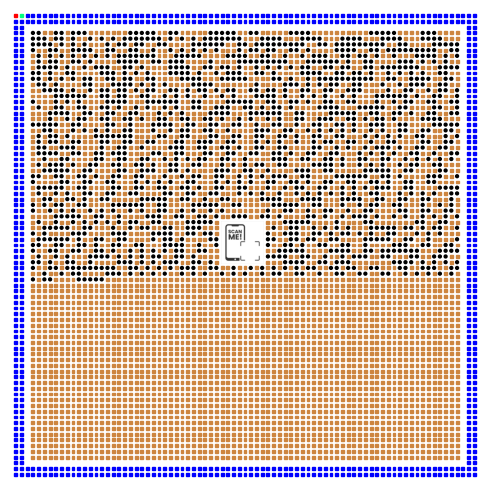


QR code généré avec succès.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from PIL import Image
import sys

# ------------------------
# Hamming (7,4) encoding
# ------------------------

def int_to_bin(n, bits=4):
    """Convertit un entier en une chaîne binaire de taille spécifiée"""
    return format(n, f'0{bits}b')

def hamming74_encode(n):
    """Encode un nombre de 4 bits en un code Hamming(7,4)"""
    d = [int(b) for b in int_to_bin(n, 4)]  # Convertit le nombre en bits
    p1 = d[0] ^ d[1] ^ d[3]  # Parité p1
    p2 = d[0] ^ d[2] ^ d[3]  # Parité p2
    p3 = d[1] ^ d[2] ^ d[3]  # Parité p3
    return [p1, p2, d[0], p3, d[1], d[2], d[3]]  # Retourne le code Hamming

def encode_hamming_message(msg):
    """Encode un message entier (chaîne de caractères) en utilisant le code Hamming(7,4)"""
    encoded_bits = []
    for char in msg:
        ascii_val = ord(char)  # Obtenir la valeur ASCII du caractère
        high_nibble = (ascii_val >> 4) & 0x0F  # Extraire le nibble supérieur
        low_nibble = ascii_val & 0x0F  # Extraire le nibble inférieur
        encoded_bits.extend(hamming74_encode(high_nibble))  # Encoder le nibble supérieur
        encoded_bits.extend(hamming74_encode(low_nibble))  # Encoder le nibble inférieur
    return encoded_bits  # Retourne tous les bits encodés

def create_qr_matrix(data_bits, base_size=14):
    """Crée une matrice QR vide à partir des bits de données"""
    total_bits = len(data_bits)  # Nombre total de bits à encoder
    min_size = base_size  # Taille de base de la matrice
    
    usable_area = lambda s: s * s  # Calcul de l'aire utilisable pour une taille donnée
    size = min_size
    while usable_area(size) < total_bits:  # Augmente la taille de la matrice tant que l'aire est insuffisante
        size += 2

    qr_matrix = np.zeros((size, size), dtype=int)  # Créer une matrice vide de la taille nécessaire

    # Écriture des bits dans la matrice
    index = 0
    for y in range(size):
        for x in range(size):
            if index < total_bits:
                qr_matrix[y, x] = data_bits[index]  # Remplir la matrice avec les bits
                index += 1
    return qr_matrix  # Retourne la matrice QR remplie

def calculate_matrix_size():
    """Calcule la taille de la matrice de données pour un message de longueur 400 caractères"""
    message_length=400  # Longueur du message en caractères
    inner_margin=1  # Marge intérieure pour le code QR
    required_bits = message_length * 14  # Nombre de bits nécessaires
    min_inner_size = int(np.ceil(np.sqrt(required_bits)))  # Taille minimale de la matrice
    data_size = min_inner_size + 2 * inner_margin  # Taille totale incluant les marges
    return max(10, data_size)  # Retourne la taille de la matrice, avec une taille minimale de 10

def add_central_image(ax, image_path, img_x_start, img_y_start, img_width, img_height):
    """Ajoute une image centrale au QR code"""
    if image_path:
        try:
            img = Image.open(image_path)  # Ouvre l'image
            img = img.convert('RGB')  # Convertit l'image en RGB
            img = img.resize((120, 120))  # Redimensionne l'image à 120x120 pixels
            ax.imshow(img, extent=[img_x_start, img_x_start + img_width, 
                                  img_y_start, img_y_start + img_height],
                     zorder=10)  # Affiche l'image sur le QR code
        except Exception as e:
            print(f"Erreur lors du chargement de l'image: {e}")  # Affiche un message d'erreur si l'image ne peut pas être chargée
            # Dessine un carré blanc si l'image ne peut pas être chargée
            ax.add_patch(Rectangle(
                (img_x_start, img_y_start),
                img_width, img_height, color='white', ec='black', zorder=5))
    else:
        print("aucune image fournie")  # Affiche un message si aucune image n'est fournie
        ax.add_patch(Rectangle(
            (img_x_start, img_y_start),
            img_width, img_height, color='white', ec='black', zorder=5))

def generate_custom_qr_image(image_path=None, border_size=2, encoded_bits=None, inner_margin=1, image_size=8):
    """Génère une image QR personnalisée avec une image centrale et les bits encodés"""
    # 1. Calculer la taille de la matrice
    data_size = calculate_matrix_size()  # Calculer la taille de la matrice de données
    total_size = data_size + 2 * border_size  # Taille totale incluant les bordures
    
    # 2. Créer une matrice vide avec bordures
    matrix = np.zeros((total_size, total_size), dtype=int)
    
    # 3. Remplir la zone de données (au centre)
    data_zone = matrix[border_size:border_size+data_size, border_size:border_size+data_size]
    
    # Calculer la zone centrale à laisser vide (pour l'image)
    center_start = (data_size - image_size) // 2
    center_end = center_start + image_size
    
    # Remplir la zone de données avec les bits en évitant la zone centrale
    bit_index = 0
    for y in range(inner_margin, data_size - inner_margin):
        for x in range(inner_margin, data_size - inner_margin):
            # Vérifier si on est dans la zone centrale réservée à l'image
            if (center_start <= y < center_end and center_start <= x < center_end):
                data_zone[y, x] = 0  # Laisser la zone vide (blanche)
                continue
                
            if bit_index < len(encoded_bits):
                data_zone[y, x] = encoded_bits[bit_index]  # Remplir avec les bits encodés
                bit_index += 1
            else:
                data_zone[y, x] = 0  # Remplissage avec des 0
    
    # 4. Préparer la visualisation
    fig, ax = plt.subplots(figsize=(5, 5))  # Créer un graphique
    ax.set_aspect('equal')  # Fixer l'aspect du graphique
    ax.axis('off')  # Désactiver les axes

    # Paramètres visuels
    element_size = 0.025  # Taille d'un élément du QR code
    spacing = 0.025  # Espacement entre les éléments
    circle_radius = element_size / 2  # Rayon des cercles
    square_half = element_size / 2  # Demi-longueur des carrés

    # Positions des marqueurs (peuvent être ajustées)
    red_pos = (0, 0)  # Position du marqueur rouge
    green_pos = (0, 1)  # Position du marqueur vert

    # Calcul des coordonnées pour l'image centrale
    center_display_start_x = border_size + center_start
    center_display_end_y = border_size + center_end

    # Convertir en coordonnées d'affichage
    img_x_start = center_display_start_x * (element_size + spacing) - square_half
    img_y_start = (total_size - center_display_end_y) * (element_size + spacing) - square_half
    img_width = image_size * element_size + (image_size - 1) * spacing
    img_height = image_size * element_size + (image_size - 1) * spacing

    # Remplir le QR code avec les éléments
    for y in range(total_size):
        for x in range(total_size):
            display_x = x
            display_y = total_size - 1 - y
            adjusted_x = display_x * (element_size + spacing)
            adjusted_y = display_y * (element_size + spacing)

            # Marqueurs rouges et verts
            if (y, x) == red_pos:
                ax.add_patch(Rectangle(
                    (adjusted_x - square_half, adjusted_y - square_half),
                    element_size, element_size, color='red', ec='red')) 
            elif (y, x) == green_pos:
                ax.add_patch(Rectangle(
                    (adjusted_x - square_half, adjusted_y - square_half),
                    element_size, element_size, color='springgreen', ec='springgreen'))
            elif (border_size <= y < border_size + data_size and 
                  border_size <= x < border_size + data_size and
                  not (y < border_size + inner_margin or 
                       y >= border_size + data_size - inner_margin or
                       x < border_size + inner_margin or 
                       x >= border_size + data_size - inner_margin)):
                
                # Vérifier si on est dans la zone centrale réservée à l'image
                y_data = y - border_size
                x_data = x - border_size
                if (center_start <= y_data < center_end and center_start <= x_data < center_end):
                    pass  # On gère l'image séparément
                else:
                    # Zone de données normale
                    if matrix[y, x] == 1:
                        ax.add_patch(Circle(
                            (adjusted_x, adjusted_y), circle_radius, color='black'))
                    else:
                        ax.add_patch(Rectangle(
                            (adjusted_x - square_half, adjusted_y - square_half),
                            element_size, element_size, color='peru', ec='peru'))
            else:
                # Bordures et marges
                if (border_size <= y < border_size + data_size and 
                    border_size <= x < border_size + data_size):
                    ax.add_patch(Rectangle(
                        (adjusted_x - square_half, adjusted_y - square_half),
                        element_size, element_size, color='white', ec='white'))
                else:
                    ax.add_patch(Rectangle(
                        (adjusted_x - square_half, adjusted_y - square_half),
                        element_size, element_size, color='blue', ec='blue'))

    # Ajouter l'image centrale en utilisant la nouvelle méthode
    add_central_image(ax, image_path, img_x_start, img_y_start, img_width, img_height)

    total_display_size = total_size * (element_size + spacing)
    ax.set_xlim(-0.05, total_display_size)
    ax.set_ylim(-0.05, total_display_size)

    plt.tight_layout()
    plt.savefig("Qr_code.png", dpi=300, bbox_inches='tight', facecolor='white')  # Sauvegarder l'image
    plt.show()  # Afficher l'image

    return matrix  # Retourner la matrice QR générée

# -------------------
# Programme principal
# -------------------

if __name__ == "__main__":
    # Message à encoder dans le QR code
    message = "https://www.google.com/search?q=uca&oq=uca+&gs_lcrp=EgZjaHJvbWUqBwgAEAAYjwIyBwgAEAAYjwIyDAgBECMYJxiABBiKBTIHCAIQLhiABDIMCAMQABgUGIcCGIAEMgcIBBAAGIAEMgYIBRBFGDwyBggGEEUYPDIGCAcQRRg80gEHMzc3ajBqN6gCALACAA&sourceid=chrome&ie=UTF-8"
    # Vérification de la longueur
    if len(message) > 400:
        print("Le message est trop long (max 400 caractères).")
        sys.exit()  # Arrêter le programme si le message est trop long

    # Encoder le message en utilisant le code Hamming
    encoded_bits = encode_hamming_message(message)
    
    # Créer la matrice QR à partir des bits encodés
    qr_matrix = create_qr_matrix(encoded_bits, base_size=14)
    
    # Générer l'image QR personnalisée avec l'image centrale
    generate_custom_qr_image(image_path="Scan_me.jpg", border_size=2, encoded_bits=encoded_bits, inner_margin=1, image_size=8)
    
    print("\nQR code généré avec succès.")  # Message de confirmation
